# Lab 3 - Reciever Operating Characteristics

6252320 - Leon Debnath

## 1. Introduction 
 
ROC  analysis  of  probabilistic  classifiers  is  important  topic  in  machine  learning.  It  is  used when we need to decide whether the posterior class probabilities that the classifiers assign to test instances allow us to separate correctly the instances according to their class labels.  In this lab you will implement a class ROC in Python that can be used for ROC analysis for two  class  problems  (e.g.  problems  with  positive  and  negative  classes).  Description  of  the application program interface of this class is provided in the next section.   

## 2. Lab Tasks 
We  need  to  implement  the  lab  tasks  related  to  class  ROC  in  the  following  context.  A probabilistic classifer $h$ has been first trained on some labeled training data and then tested on  a  test  set  of  labeled  test  instances.  For  each  test  instance  $x$  classifier  $h$  has  outputted posterior probability of the positive class and posterior probability of the negative class. The class probabilities of the test instances are saved in a `pandas.DataFrame` object `Probs` and the true class labels of the test instances are saved in a `pandas.DataFrame` object `TrueClass`. The correspondence between object `Probs` and object `TrueClass` is index-based: the positive-class probability of the $i^{th}$ instance $x$ is the $i^{th}$ element of $P$ and the true-class label of the $i^{th}$ instance is the $i^{th}$ element of `TrueClass`. 

In the context we have just described, supply class ROC with the following methods:

In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import normal
import scipy.integrate as integrate


In [137]:
class ROC:
    
    #######
    #  A.  
    #######
    # Parametric constructor ROC that can accept two input parameters:
    #
    #     a. object Probs that contains the estimated probabilities of
    #        the test instances for the positive class, and 
    #
    #     b. object TrueClass that contains the true class of the test
    #        instances. Note that Probs and  TrueClass have to be saved
    #        in instance fields of ROC objects to allow operation of 
    #        other methods in ROC. 
    
    def __init__(self, probs, true_class):
        self.probs = probs
        self.true_class = true_class
        self.data = pd.DataFrame({'pos': probs['pos'],
                                  'neg': probs['neg'],
                                  'class': true_class['class']})
        self.coords = None
        self.coords_avg = None
        self.stored = False
        self.ave_x = 0
        self.ave_y = 0


    #######
    #  B.
    #######
    # Method compute_ROC_coordinates that computes the TPr and FPr coordinates
    # of the ROC curve from the positive class probabilities and true classes
    # of the test instances (see Appendix A for pseudocode).  One of the main
    # problems when implementing method compute_ROC_coordinates  is  to  decide
    # how  to  handle  test  instances  of opposite  classes  that  have  the
    # same  probability  for  the  positive  class.  Propose  one strategy and
    # implement this strategy in method compute_ROC_coordinates.
        
    def compute_coordinates(self):       
        fp = 0
        tp = 0
        p = true_class['class'].value_counts()[1]
        n = true_class['class'].value_counts()[0]
        
        coords = {}
        prob_prev = -np.inf
        
        # Sort probabilities by positive instance in decreasing order
        data = self.data.sort_values('pos', axis=0, ascending=False)
             
        for i in range(len(data)):               
            if data.loc[i,'pos'] != prob_prev:
                coords[i] = [fp/n, tp/p]
                prob_prev = data.loc[i,'pos']
            
                if data.loc[i,'class'] == 1:
                    tp += 1
                else:
                    fp += 1
        
        self.coords = pd.DataFrame.from_dict(coords, orient='index')
        return self.coords
    
    
    def compute_coordinates_avg(self):       
        fp = 0
        tp = 0
        p = true_class['class'].value_counts()[1]
        n = true_class['class'].value_counts()[0]
        
        X = []
        Y = []
        coords = {}
        prob_prev = -np.inf
        
        # Sort probabilities by positive instance in decreasing order
        data = self.data.sort_values('pos', axis=0, ascending=False)
        
        for i in range(len(data)):               
            
            if data.loc[i,'pos'] == prob_prev:
                self.store_point(fp/n, tp/p)
            
            elif data.loc[i,'pos'] != prob_prev:
                
                if self.stored:
                    x, y = self.retrieve_ave()
                    coords[i] = [x, y]
            
                coords[i] = [fp/n, tp/p]
            
            if data.loc[i,'class'] == 1:
                tp += 1
            else:
                fp += 1
            
            prob_prev = data.loc[i,'pos']
        
        self.coords_avg = pd.DataFrame.from_dict(coords, orient='index')
        return self.coords_avg
    
    def store_point(self, x, y):
        if x > self.ave_x: 
            self.ave_x = x
        if y > self.ave_y: 
            self.ave_y = y
        self.stored = True
    
    def retrieve_ave(self):
        x = self.ave_x
        y = self.ave_y
        self.ave_x = 0
        self.ave_y = 0
        self.stored = False
        return x, y
        
    #######
    #  C.
    #######
    # Method plot_ROC that plots the ROC curve
    
    def plot(self):
        if self.coords is None:
            self.compute_coordinates()
        plt.plot(self.coords[0], self.coords[1])
        
    
    def plot_avg(self):
        if self.coords_avg is None:
            self.compute_coordinates_avg()
        plt.plot(self.coords_avg[0], self.coords_avg[1])
    
    
    #######
    #  D.
    #######
    # Method compute_AUCROC that computes the area under curve (AUC) 
    # of the ROC curve from the positive-class probabilities and 
    # true classes  of the test instances (for the  sake  of  
    # computational  efficiency,  the  method  assumes  that  we  first
    # run  method compute_ROC_coordinates).
    
    def AUC(self):
        X = self.coords[0]
        Y = self.coords[1]
        area = integrate.trapz(X, Y)
        return area
    
    def AUC_avg(self):
        X = self.coords_avg[0]
        Y = self.coords_avg[1]
        area = integrate.trapz(X, Y)
        return area

## Part B
To resolve conflicts where $P(pos) = P(neg)$ in the pseudocode the last probability recorded is stored and if the $i^th$ probability is not the same the threshold will be increased. This causes an issue as the sorting of positive and negative classes of the same values are not necessarily in any order such that three instances each with $P(pos) = 0.7$ could be ordered in $3^3$ different ways, with some orderings being 'optimistic; i.e. ${1, 1, 0}$ and others 'pessimistic': ${0,1,1}$

The alternative is to calculate the average of the optimistic and pessimistic elements and not outputting a ROC point until all have been taken into account.  This should provider a smoother curve with few concavities.
[T.Fawcett 2003](https://www.hpl.hp.com/techreports/2003/HPL-2003-4.pdf). 

The `compute_coords_avg` and `plot_avg` methods use this averaging technique to plot the ROC curves ad show a smoother curve in part E

Area under curve: 0.5272727272727272
Area under curve: 0.5272727272727272


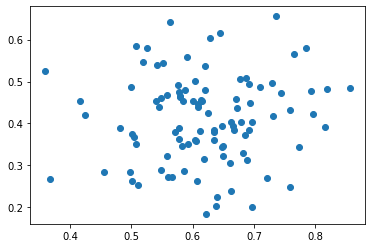

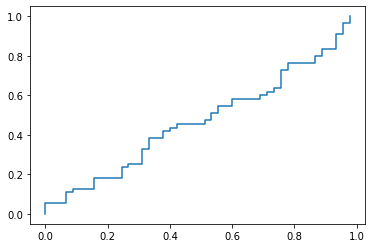

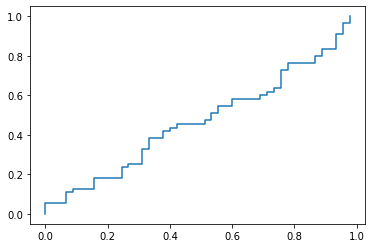

In [142]:
# Create a random data set to test while building 
probs = pd.DataFrame({'pos': normal(loc=0.6, scale=0.1, size=100),
                      'neg': normal(loc=0.4, scale=0.1, size=100)})
true_class = pd.DataFrame({'class': [random.randint(0,1) for i in range(100)]})

plt.figure(1)
plt.scatter(probs['pos'], probs['neg'])

roc = ROC(probs, true_class)

plt.figure(2)
roc.plot()
print(str.format('Area under curve: {0}', roc.AUC()))

plt.figure(3)
roc.plot_avg()
print(str.format('Area under curve: {0}', roc.AUC_avg()))

# Note that the two plots are identical as the random values rarely seem to 
# have identical values

In [139]:
########
# Part E 
########
# Provide code to test all the methods of class ROC with a probabilistic classifier from 
# sklearn or the kNN classifier from Lab 2. The data set is the diabetes data set. 

from sklearn.model_selection import train_test_split

data = pd.read_csv('diabetes.csv')
data.head()
Y = data['class']
X = data.drop(['class'],axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.34, random_state=10)

# Create a set of true classes for the current dataset
true_class = []
for instance in Y_test:
    if instance == 'tested_positive':
        true_class.append(1)
    else:
        true_class.append(0)
true_class = pd.DataFrame({'class': true_class})    


Area under curve: 0.3331433637284702
Area under curve: 0.48274442755825736


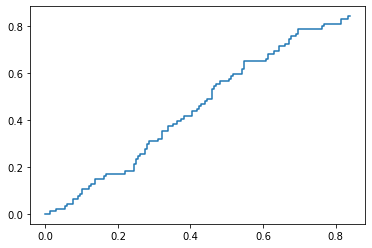

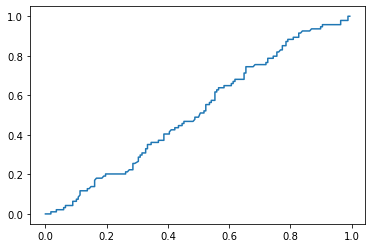

In [141]:
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=10)
classifier.fit(X_train, Y_train)
probs = classifier.predict_proba(X_test).T
probs = pd.DataFrame({'pos': probs[0],
                      'neg': probs[1]})
roc = ROC(probs, true_class)

plt.figure(1)
roc.plot()
print(str.format('Area under curve: {0}', roc.AUC()))

plt.figure(2)
roc.plot_avg()
print(str.format('Area under curve: {0}', roc.AUC_avg()))